Konvolucijski model

In [ ]:
import torch
from torch import nn
from torch.nn import functional



class ConvolutionalModel(nn.Module):
  """A simple model for generating a convolutional neural network.
  It contains two convolutional layers, two pooling layers, and three 
  fully connected layers. In constructor you can specify parameters
  specific to your training set.
  """
  def __init__(self, in_channels, conv1_width, fc1_width, class_count):
    super(ConvolutionalModel, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, conv1_width, kernel_size=5, stride=1,  bias=True)
    self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
    self.conv2 = nn.Conv2d(conv1_width, conv1_width * 2, kernel_size=5, stride=1,  bias=True)
    self.pool2= nn.MaxPool2d(kernel_size=3, stride=2)
    self.dropout = nn.Dropout2d(p=0.5)
    self.fc1 = nn.Linear(fc1_width * 4, fc1_width * 2, bias=True)
    self.fc2 = nn.Linear(fc1_width * 2, fc1_width, bias=True)
    self.fc_logits = nn.Linear(fc1_width, class_count, bias=True)

    # parametri su već inicijalizirani pozivima Conv2d i Linear
    # ali možemo ih drugačije inicijalizirati
  
  def forward(self, x):
    """Forward propagation for training of the neural network.
    Classifies the given batch of input tensors.
    Parameters
    ----------
    self: ConvolutionalModel
      For calling the needed layers.
    x: torch.Tensor
      Batch of tensors for classification.
    Returns
    -------
    logits
      Predicitons of classes for the given batch of tensors
    """
    h = self.conv1(x)
    h = functional.relu(h)  
    h = self.pool1(h)

    h = self.conv2(h)
    h = functional.relu(h)
    h = self.pool2(h)
    h = self.dropout(h)

    h = h.view(h.shape[0], -1)

    #print(h.size())

    h = self.fc1(h)
    h = functional.relu(h)

    h = self.fc2(h)
    h = functional.relu(h)
    logits = self.fc_logits(h)
    return logits

Priprema drivea

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Učitavanje

In [ ]:
import torchvision
import torchvision.transforms as transforms

#Simple data loading for usage in
#the rest of the training.
#Before using for the first time set download to
#true

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))])

trainset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=False, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=50,
                                         shuffle=True, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
labeledDataCount = 1000
trainLabeled = False

Evaluacija

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn


def evaluate(net, type):
    """
    Performs the evaluation of the current performance of a
    given convolutional network. It can perform the evaluation on 
    both training and testing sets. Standard evaluation metrics are
    calcualted such as, accuracy and confusion matrix.
    Parameters
    ----------
    net: ConvolutionalModel
        ConvNet whose performance needs to be evaluated.
    type: bool
        True if eval is made on testing set, false otherwise
    Return
    ------
    loss
        Current loss on the chosen set
    accuracy
        Current acc on the chosen set
    """
    device = torch.device('cuda')
    f = open("/content/drive/MyDrive/results/rs_data" + str(labeledDataCount) + ".txt", "a+")
    net.eval()
    net.to(device=device)
    total = 0
    correct = 0
    confMatrix = np.zeros((10, 10), int)
    lossFunc = nn.CrossEntropyLoss()
    accLoss = 0
    if type:
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images = images.to(device=device)
                labels = labels.to(device=device)

                output = net.forward(images)
                loss = lossFunc(output, labels)
                _, predictions = torch.max(output.data, 1)
                total += labels.size(0)
                accLoss += loss.item()
                correct += (predictions == labels).sum().item()
                for j in range(labels.size(0)):
                    confMatrix[predictions[j], labels[j]] += 1
    else:
        with torch.no_grad():
            for data in trainloader:
                images, labels = data
                images = images.to(device=device)
                labels = labels.to(device=device)

                output = net.forward(images)
                loss = lossFunc(output, labels)
                _, predictions = torch.max(output.data, 1)
                total += labels.size(0)
                accLoss += loss.item()
                correct += (predictions == labels).sum().item()
                for j in range(labels.size(0)):
                    confMatrix[predictions[j], labels[j]] += 1

    print("Accuracy of the neural network on CIFAR_10 is: %.2f %%" %((correct/total)*100))
    #print(data_load.classes)
    f.write("Accuracy: " + str(((correct/total)*100)) + '\n')
    f.write(str(classes) + '\n')
    f.write(str(confMatrix) + '\n')
    #print(confMatrix)
    prec, recall = specificMetrics(confMatrix)
    f.write(str(prec) + '\n')
    f.write(str(recall) + '\n')
    f.close()
    return (accLoss/(total/trainloader.batch_size)), (correct/total)

def specificMetrics(confMatrix):
    """
    Calculates precision and recall from a given confusion
    matrix and returns calculated metrics.
    Parameters
    ----------
    confMatrix: n x n numpy array
        Made from the predictions and true labels of a
        given set of data
    Return
    ------
    precc
        Precision on all classes
    recal 
        Recall on all classes
    """
    precc = np.zeros(np.size(confMatrix, 0))
    recal = np.zeros(np.size(confMatrix, 0))
    for i in range(np.size(confMatrix, 0)):
        tp = 0
        fp = 0
        fn = 0
        for j in range(np.size(confMatrix, 0)):
            if i == j:
                tp += confMatrix[i, j]
            else:
                fn += confMatrix[j, i]
                fp += confMatrix[i, j]
            
        precc[i] += tp/(tp + fp)
        recal[i] += tp/(tp + fn)

    return precc, recal

Crtanje

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os


def plot_training_progress(save_dir, data):
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))

  linewidth = 2
  legend_size = 10
  train_color = 'm'
  val_color = 'c'

  num_points = len(data['train_loss'])
  x_data = np.linspace(1, num_points, num_points)
  ax1.set_title('Cross-entropy loss')
  ax1.plot(x_data, data['train_loss'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax1.plot(x_data, data['valid_loss'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax1.legend(loc='upper right', fontsize=legend_size)
  ax2.set_title('Average class accuracy')
  ax2.plot(x_data, data['train_acc'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax2.plot(x_data, data['valid_acc'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax2.legend(loc='upper left', fontsize=legend_size)
  ax3.set_title('Learning rate')
  ax3.plot(x_data, data['lr'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='learning_rate')
  ax3.legend(loc='upper left', fontsize=legend_size)

  save_path = os.path.join(save_dir, 'training_plot' + str(labeledDataCount) + '.png')
  print('Plotting in: ', save_path)
  plt.savefig(save_path)

Treniranje

Files already downloaded and verified
Files already downloaded and verified
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
1000
Epoch: 1, Iteration:     0, Loss: 2.328
Epoch: 1, Iteration:   500, Loss: 2.317
Epoch: 1, Iteration:  1000, Loss: 2.276
Epoch: 1, Iteration:  1500, Loss: 0.000
Epoch: 1, Iteration:  2000, Loss: 2.347
Epoch: 1, Iteration:  2500, Loss: 0.000
Epoch: 1, Iteration:  3000, Loss: 2.274
Epoch: 1, Iteration:  3500, Loss: 2.243
Epoch: 1, Iteration:  4000, Loss: 2.327
Epoch: 1, Iteration:  4500, Loss: 0.000
Epoch: 1, Iteration:  5000, Loss: 2.321
Epoch: 1, Iteration:  5500, Loss: 0.000
Epoch: 1, Iteration:  6000, Loss: 0.000
Epoch: 1, Iteration:  6500, Loss: 2.516
Epoch: 1, Iteration:  7000, Loss: 2.250
Epoch: 1, Iteration:  7500, Loss: 2.224
Epoch: 1, Iteration:  8000, Loss: 0.000
Epoch: 1, Iteration:  8500, Loss: 2.349
Epoch: 1, Iteration:  9000, Loss: 2.280
Epoch: 1, Iteration:  9500, Loss: 0.000
Epoch: 1, Iteration: 10000, Loss: 2.181
Epoch: 1, Iteration: 10500,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in long_scalars


Streaming output truncated to the last 5000 lines.
Epoch: 32, Iteration: 24000, Loss: 0.888
Epoch: 32, Iteration: 24500, Loss: 0.060
Epoch: 32, Iteration: 25000, Loss: 0.801
Epoch: 32, Iteration: 25500, Loss: 0.058
Epoch: 32, Iteration: 26000, Loss: 0.641
Epoch: 32, Iteration: 26500, Loss: 0.039
Epoch: 32, Iteration: 27000, Loss: 0.050
Epoch: 32, Iteration: 27500, Loss: 0.256
Epoch: 32, Iteration: 28000, Loss: 0.044
Epoch: 32, Iteration: 28500, Loss: 0.064
Epoch: 32, Iteration: 29000, Loss: 1.302
Epoch: 32, Iteration: 29500, Loss: 0.070
Epoch: 32, Iteration: 30000, Loss: 0.063
Epoch: 32, Iteration: 30500, Loss: 0.054
Epoch: 32, Iteration: 31000, Loss: 1.166
Epoch: 32, Iteration: 31500, Loss: 0.394
Epoch: 32, Iteration: 32000, Loss: 0.072
Epoch: 32, Iteration: 32500, Loss: 1.954
Epoch: 32, Iteration: 33000, Loss: 0.143
Epoch: 32, Iteration: 33500, Loss: 0.098
Epoch: 32, Iteration: 34000, Loss: 0.478
Epoch: 32, Iteration: 34500, Loss: 3.577
Epoch: 32, Iteration: 35000, Loss: 0.076
Epoch:

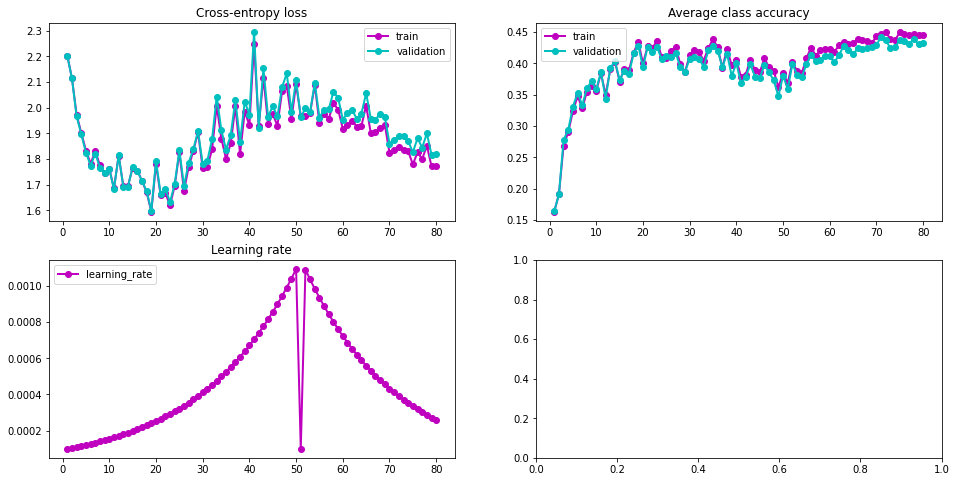

In [ ]:
import torch.optim as optim
from torch import nn
import torch
import torchvision
import torchvision.transforms as transforms
import math
from PIL import Image
from torchvision.datasets import CIFAR10
import numpy as np

#Simple data loading for usage in
#the rest of the training.
#Before using for the first time set download to
#true

trainTransform = transforms.Compose([
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))])

validTransform = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))])

class CifarDataset(CIFAR10):
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)
        img1 = img
        img2 = img

        if self.transform is not None:
            img1 = self.transform(img)
            img2 = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img1, img2, target

def maskForTrain():
    classLabels = np.zeros(10)
    counter = 0
    for i in range(len(trainSet)):
        if counter == labeledDataCount:
            trainSet.targets[i] = -1
        else:
            target = trainSet.targets[i]
            if classLabels[target] < labeledDataCount / 10:
                classLabels[target] += 1
                counter += 1
            else:
                trainSet.targets[i] = -1

    print(classLabels)

trainSet = CifarDataset(root='/content/drive/MyDrive/data', train=True,
                    download=True, transform=trainTransform)
testSet = CIFAR10(root='/content/drive/MyDrive/data', train=False,
                    download=True, transform=validTransform)

if trainLabeled:
    maskForTrain()
    lista = []
    for i in range(len(trainSet)):
        if trainSet.targets[i] != -1:
            lista.append(i)

    subtrainset = torch.utils.data.Subset(trainSet, lista)

    print(len(subtrainset))

    trainLoader = torch.utils.data.DataLoader(subtrainset, batch_size=50,
                                          shuffle=True, num_workers=0)
else:
    maskForTrain()
    cnt = 0
    for i in range(len(trainSet)):
        if trainSet.targets[i] != -1:
            cnt += 1
    
    print(cnt)
    trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=50,
                                          shuffle=True, num_workers=0)




testLoader = torch.utils.data.DataLoader(testSet, batch_size=50,
                                         shuffle=True, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def update_w_t(epoch, num_epochs):
    if epoch < num_epochs:
        p = max(0.0, float(epoch) / float(num_epochs))
        p = 1.0 - p
        return math.exp(-p * p * 5.0)
    else:
        return 1.0

def trainNetwork():
    """Performs a standard procedure for training a neural network.
    Training progress after each learning epoch is evaluated in order to
    gain insigth into ConvNets continuous performance.
    Important notes
    ---------------
    Loss function: Cross entropy loss

    Optimizer: Adam
    
    Scheduler: ExponentialLR
    """
    SAVE_DIR = '/content/drive/MyDrive/plots'
    device = torch.device('cuda')
    

    epoch = 80
    epoch_rampup = 50
    epoch_rampdown = 30
    
    plot_data = {}
    plot_data['train_loss'] = []
    plot_data['valid_loss'] = []
    plot_data['train_acc'] = []
    plot_data['valid_acc'] = []
    plot_data['lr'] = []
    net = ConvolutionalModel(3, 16, 128, 10)
    net.train()
    net.to(device=device)
    f = open("/content/drive/MyDrive/results/rs_data" + str(labeledDataCount) +".txt", "a+")
    f.close()
    lossFunc = nn.CrossEntropyLoss(ignore_index=-1)
    lossFuncUnsupervised = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)
    scheduler_rampup = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.05)
    scheduler_rampdown = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


    for e in range(epoch):

        accLoss = 0.0

        w = update_w_t(e, epoch_rampup)
        if trainLabeled:
            for i, data in enumerate(trainLoader, 0):
                input, input1, labels = data
                input = input.to(device=device)
                labels = labels.to(device=device)

                optimizer.zero_grad()

                outputs_supervised = net.forward(input)

                loss = lossFunc(outputs_supervised, labels)
                loss.backward()
                optimizer.step()

                accLoss += loss.item()

                if i % 10 == 0:
                    print("Epoch: %d, Iteration: %5d, Loss: %.3f" % ((e + 1), (i * 50), loss.item()))

        else:
            for i, data in enumerate(trainLoader, 0):
                input, input1, labels = data
                input = input.to(device=device)
                input1 = input1.to(device=device)
                labels = labels.to(device=device)

                optimizer.zero_grad()

                outputs_supervised = net.forward(input)
                outputs_unsupervised = net.forward(input1)

                loss = lossFunc(outputs_supervised, labels) + (w * lossFuncUnsupervised(outputs_supervised, outputs_unsupervised) / 10)
                loss.backward()
                optimizer.step()

                accLoss += loss.item()

                if i % 10 == 0:
                    print("Epoch: %d, Iteration: %5d, Loss: %.3f" % ((e + 1), (i * 50), loss.item()))

                
    
        train_loss, train_acc = evaluate(net, False)
        val_loss, val_acc = evaluate(net, True)

        plot_data['train_loss'] += [train_loss]
        plot_data['valid_loss'] += [val_loss]
        plot_data['train_acc'] += [train_acc]
        plot_data['valid_acc'] += [val_acc]

        print("w(T) = %.3f" % w)

        if e < epoch_rampup:
            plot_data['lr'] += [scheduler_rampup.get_last_lr()]
            scheduler_rampup.step()
        else:
          plot_data['lr'] += [scheduler_rampdown.get_last_lr()]
          scheduler_rampdown.step()


    plot_training_progress(SAVE_DIR, plot_data)
    PATH = '/content/drive/MyDrive/cifar_netAdam' + str(labeledDataCount)'.pth'
    torch.save(net.state_dict(), PATH)


trainNetwork()